# Unsupervised Learning Lab

In this lab you will work through several examples of methods and applications of unsupervised learning. We will be working with the **Digits** dataset of of handwritten numbers. This dataset is convenient because Scikit-learn provides it built-in.

**NOTE**: I do not explicitly *ask* for your analyses in this notebook, but you should definitely provide them!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# Load the digits dataset and extract data and labels.
ds = load_digits()
Xs = ds.data
ys = ds.target

## 1. Clustering
In this set of exercises we will experiment with clustering of the digits dataset. One use of unsupervised techniques like K-Means Clustering is to use the discovered cluster structure to *induce* a classifier.  

### Exercise 1.1: K-means clustering
Use K-means clustering to cluster the digits dataset into 10 clusters (i.e. the "*correct*" number of clusters). After clustering the data, for each cluster center compute the sum-of-squared-distances to it and all points assigned to its cluster. This is called the cluster *inertia* and is a measure of cluster compactness.

In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(Xs)

total_inertia = kmeans.inertia_

inertia_per_cluster = []
for i in range(10):
    cluster_points = Xs[kmeans.labels_ == i]
    cluster_center = kmeans.cluster_centers_[i]
    inertia = np.sum((cluster_points - cluster_center) ** 2)
    inertia_per_cluster.append(inertia)

print(f'Total Inertia: {total_inertia:.2f}')
for i, inertia in enumerate(inertia_per_cluster):
    print(f'Cluster {i} inertia: {inertia:.2f}')

Total Inertia: 1165725.11
Cluster 0 inertia: 71958.44
Cluster 1 inertia: 167159.18
Cluster 2 inertia: 123278.03
Cluster 3 inertia: 77252.89
Cluster 4 inertia: 91951.29
Cluster 5 inertia: 159351.47
Cluster 6 inertia: 113648.95
Cluster 7 inertia: 104472.01
Cluster 8 inertia: 143841.60
Cluster 9 inertia: 112811.26


I cluster con valori di inertia più elevati come 1, 5,e 8, suggeriscono che i punti sono più dispersi o che ci sono più punti assegnati a questi cluster rispetto ad altri. Viceversa per i cluster con valori più bassi, come 0 e 3, impotizziamo che i punti in quest'ultimi sono compatti, quindi più vicini al centro del cluster, o ci sono meno punti assegnati a questi cluster.

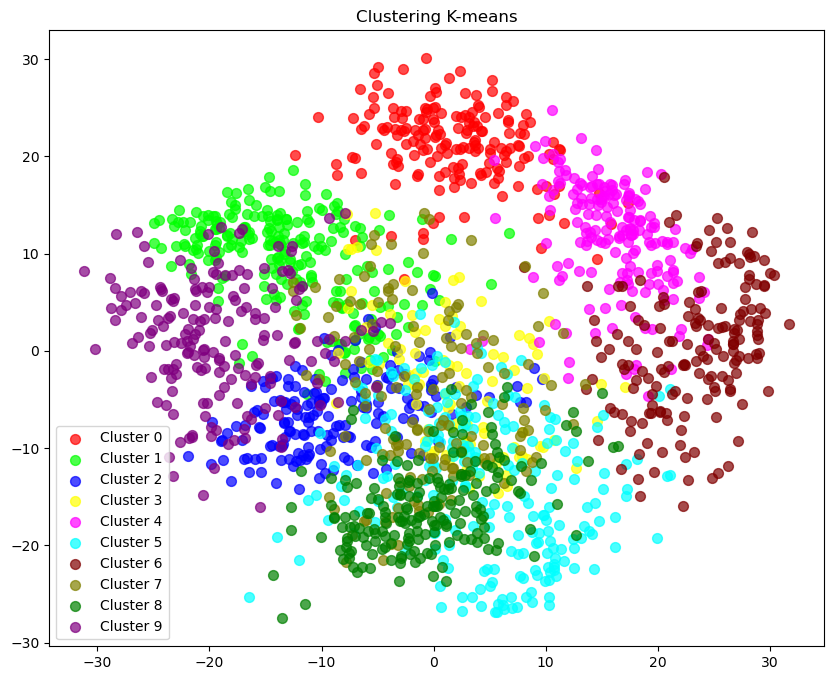

In [3]:
# riduco la dimensionalità in modo da poter visualizzare i cluster in 2D
pca = PCA(n_components=2)
Xs_pca = pca.fit_transform(Xs)

labels = kmeans.labels_

plt.figure(figsize=(10, 8))
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#800000', '#808000', '#008000', '#800080']
for i in range(10):
    cluster_points = Xs_pca[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}', s=50, alpha=0.7, c=colors[i])
plt.title('Clustering K-means')
plt.legend()
plt.show()

### Exercise 1.2: Transforming our clustering into a classifier
Now use the labels in `ys` to compute a probability distribution over all classes (i.e. a *histogram*) for each cluster. Write a function that, given a test sample $\mathbf{x}$, returns the class with maximum likelihood given by the closest cluster center. Evaluate your classifier. Compute the entropy for each cluster based on your estimated probability distributiont. Does the entropy of a cluster correlate to misclassifications of test samples closest to it?

**Note**: since you will be testing this classifier, you will want to carefully split the data into *training* and *test* splits.

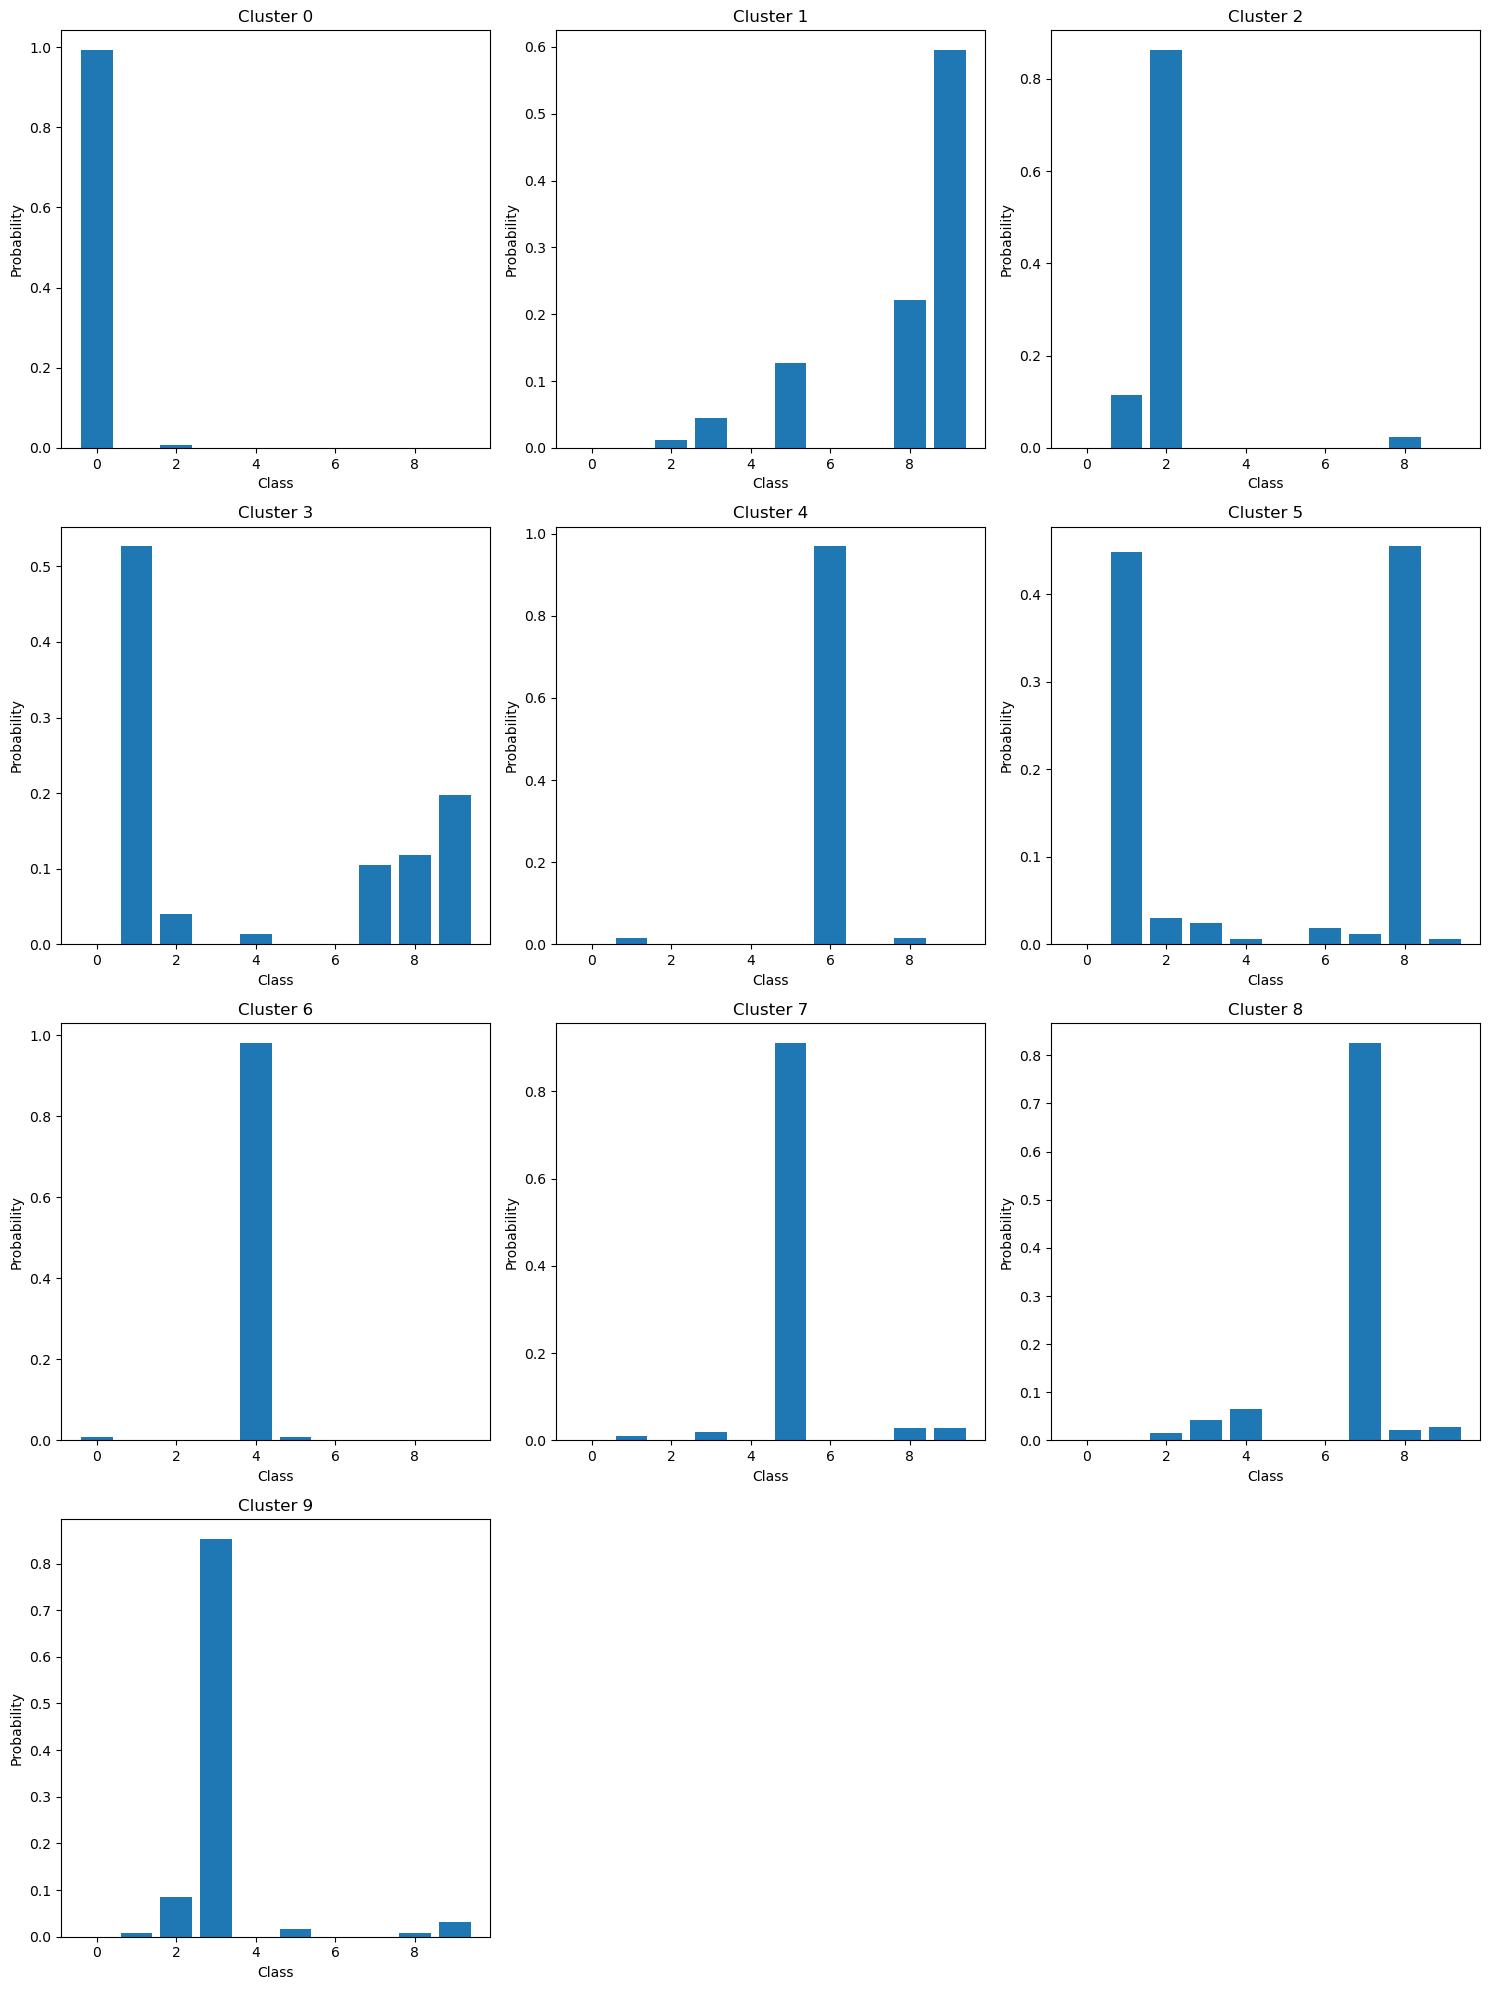

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.3, random_state=42)

train_labels = kmeans.predict(X_train) 

def calculate_cluster_probabilities(kmeans, train_labels, y_train):
    n_clusters = kmeans.n_clusters
    cluster_probabilities = np.zeros((n_clusters, 10))  
    for i in range(n_clusters):
        cluster_points = y_train[train_labels == i]
        cluster_probabilities[i] = np.bincount(cluster_points, minlength=10) / len(cluster_points)
    return cluster_probabilities

def plot_cluster_histograms(cluster_probabilities):
    n_clusters = cluster_probabilities.shape[0]
    rows = (n_clusters + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    
    for i in range(n_clusters):
        ax = axes[i // 3, i % 3]
        ax.bar(range(10), cluster_probabilities[i])
        ax.set_title(f'Cluster {i}')
        ax.set_xlabel('Class')
        ax.set_ylabel('Probability')
    
    # questo codice serve a togliere dalla griglia sotto i grafici superflui vuoti
    for i in range(n_clusters, rows * 3):
        fig.delaxes(axes[i // 3, i % 3])

    plt.tight_layout()
    plt.show()

cluster_probabilities = calculate_cluster_probabilities(kmeans, train_labels, y_train)
plot_cluster_histograms(cluster_probabilities)

In [5]:
def classify_sample(x, kmeans, cluster_probabilities):
    cluster_label = kmeans.predict([x])[0]
    return np.argmax(cluster_probabilities[cluster_label])

x_sample = X_test[0]
predicted_class = classify_sample(x_sample, kmeans, cluster_probabilities)
print(f'Predicted class: {predicted_class}')

Predicted class: 6


In [6]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import seaborn as sns

y_pred = np.array([classify_sample(x, kmeans, cluster_probabilities) for x in X_test])

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.79
Precision: 0.82
Recall: 0.79


La precision è relativamente alta, la classe predetta dal modello ha quindi un'alta probabilità di essere corretta.

Il recall invece è più basso e indica che il modello non riesce a identificare tutte le istanze positive. 

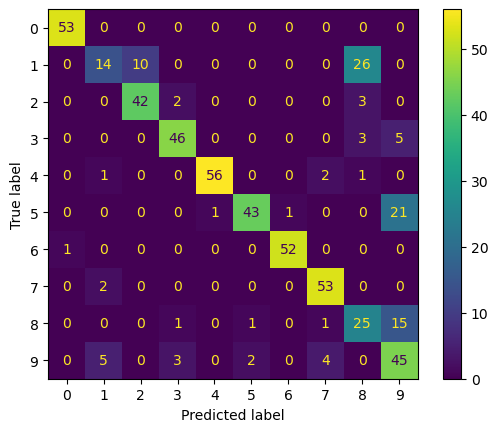

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ds.target_names)
display.plot()

La maggior parte degli elementi si trova lungo la diagonale principale, il che indica che molte predizioni sono corrette.

Le classi 1, 5 e 8 sono particolarmente problematici, vediamo infatti che ci sono diversi casi di errore. 

In [8]:
from scipy.stats import entropy

cluster_entropies = np.array([entropy(probs) for probs in cluster_probabilities])
for i, ent in enumerate(cluster_entropies):
    print(f'Cluster Entropy {i}: {ent:.2f}')

errors_per_cluster = np.zeros(kmeans.n_clusters)
for i, (x, true_label) in enumerate(zip(X_test, y_test)):
    cluster_label = kmeans.predict([x])[0]
    predicted_label = classify_sample(x, kmeans, cluster_probabilities)
    if predicted_label != true_label:
        errors_per_cluster[cluster_label] += 1

print(f'\nError per cluster: {errors_per_cluster}')

Cluster Entropy 0: 0.05
Cluster Entropy 1: 1.10
Cluster Entropy 2: 0.47
Cluster Entropy 3: 1.33
Cluster Entropy 4: 0.16
Cluster Entropy 5: 1.10
Cluster Entropy 6: 0.10
Cluster Entropy 7: 0.41
Cluster Entropy 8: 0.72
Cluster Entropy 9: 0.59

Error per cluster: [ 1. 41. 10.  8.  1. 33.  1.  3.  7.  6.]


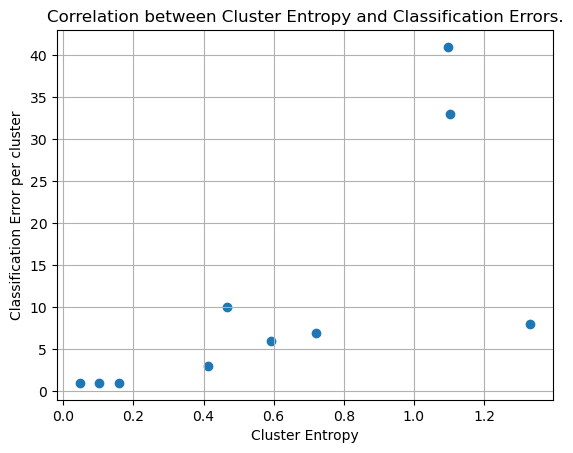

In [9]:
plt.scatter(cluster_entropies, errors_per_cluster)
plt.xlabel('Cluster Entropy')
plt.ylabel('Classification Error per cluster')
plt.title('Correlation between Cluster Entropy and Classification Errors.')
plt.grid(True)
plt.show()

## 2. Gaussian Mixture Models and Expectation Maximization
In this set of exercises we will experiment with fitting a Gaussian Mixture Model (GMM) to the digits dataset.  

### Exercise 2.1: Fitting a GMM
Fit a GMM (using `sklearn.mixture.GaussianMixture`) with 10 mixture components to the digits dataset. 

In [10]:
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore") # per nascondere dall'output un warning

gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(X_train)
train_labels = gmm.predict(X_train)  

### Exercise 2.2: Transforming the GMM into a classifier
Use the `predict_proba()` method of your fit GMM to obtain the probability distribution over the mixture components for all samples in the training set. Use these, together with the true labels `ys`, to construct a classifier as above with K-means. Evaluate your classifier. Repeat the experiment with more mixture components.

Number of mixture components: 5

Accuracy: 0.46
Precision: 0.77
Recall: 0.46



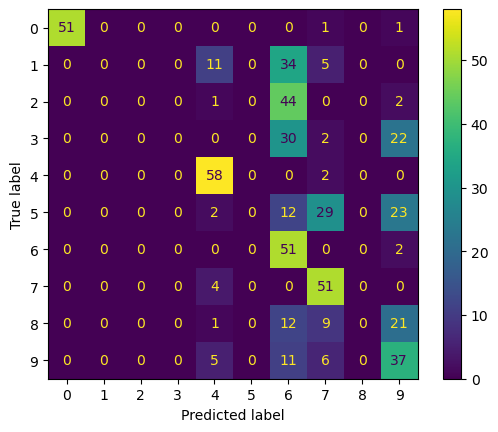

Number of mixture components: 10

Accuracy: 0.78
Precision: 0.84
Recall: 0.78



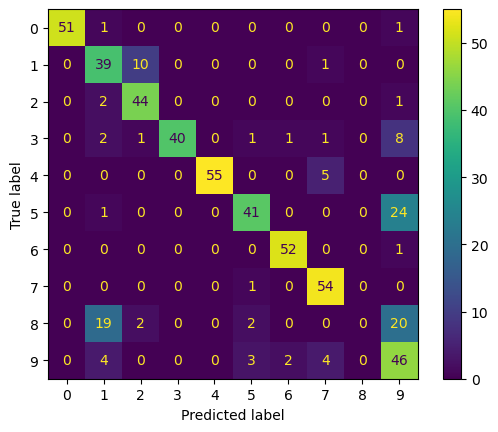

Number of mixture components: 15

Accuracy: 0.78
Precision: 0.83
Recall: 0.78



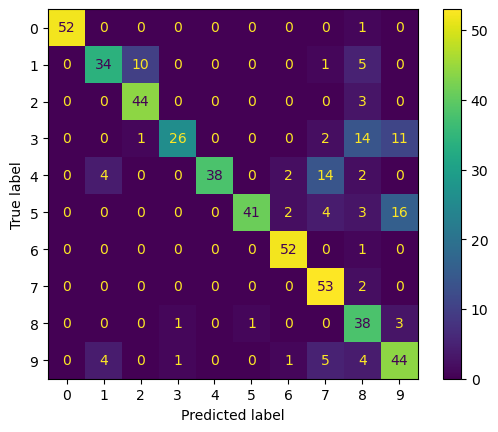

Number of mixture components: 20

Accuracy: 0.73
Precision: 0.81
Recall: 0.73



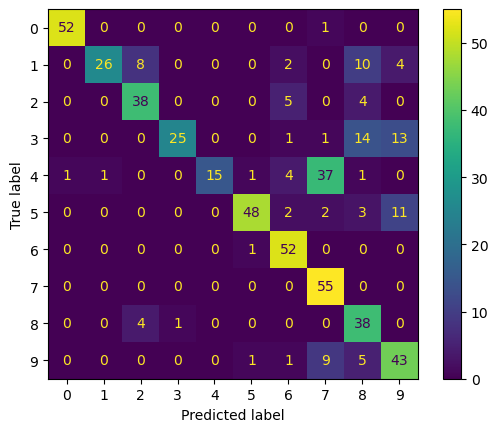

In [11]:
def fit_gmm_and_classify(n_components, X_train, X_test, y_train, y_test):
    
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train)
    train_labels = gmm.predict(X_train)  
    train_probabilities = gmm.predict_proba(X_train)  

    cluster_probabilities = calculate_gmm_cluster_probabilities(train_probabilities, y_train)

    y_pred = np.array([classify_sample_gmm(x, gmm, cluster_probabilities) for x in X_test])

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f'Number of mixture components: {n_components}\n')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}\n')
    
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ds.target_names).plot()
    plt.show()

def calculate_gmm_cluster_probabilities(train_probabilities, y_train):
        n_clusters = train_probabilities.shape[1]
        cluster_probabilities = np.zeros((n_clusters, 10))  
        for i in range(n_clusters):
            cluster_points = np.dot(train_probabilities[:, i], np.eye(10)[y_train])
            cluster_probabilities[i] = cluster_points / cluster_points.sum()
        return cluster_probabilities
    
def classify_sample_gmm(x, gmm, cluster_probabilities):
        cluster_probs = gmm.predict_proba([x])[0]
        class_probs = np.dot(cluster_probs, cluster_probabilities)
        return np.argmax(class_probs)


for n_components in [5, 10, 15, 20]:
    fit_gmm_and_classify(n_components, X_train, X_test, y_train, y_test)

Tra i quattro, il modello con 10 componenti sembra essere il migliore in termini di prestazioni. Aumentando questo numero si nota un netto peggioramento. 

Il modello peggiore però rimane quello con 5 componenti che non classifica quasi mai bene i dati.

### Exercise 2.3: Sampling from the GMM
Use the `sample()` method on a GMM fit to the digits data to generate random samples from the learned distribution. Visualize these samples in the original feature space. Are there some digits better reconstructed than others? How might you determine *which* ones are better captured?

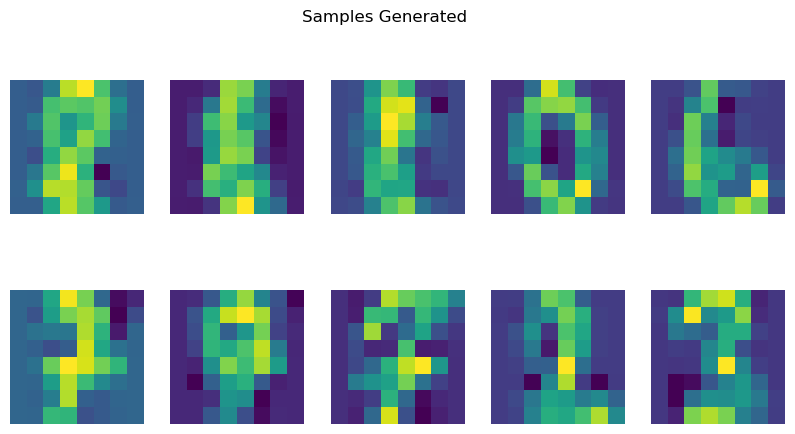

In [12]:
n_samples = 10  
samples, _ = gmm.sample(n_samples)

def plot_generated_samples(samples, n_row, n_col):
    fig, axes = plt.subplots(n_row, n_col, figsize=(10, 5))
    for i, sample in enumerate(samples):
        ax = axes[i // n_col, i % n_col]
        ax.imshow(sample.reshape(8, 8))
        ax.axis('off')
    plt.suptitle('Samples Generated')
    plt.show()

plot_generated_samples(samples, 2, 5)

Vediamo che ci sono delle cifre meglio ricostruite di altre, come ad esempio 0, 6 e 3 rispettivamente le ultime due cifre della prima riga e l'ultima della seconda riga.

Per determincare quali sono quelle "catturate" meglio, possiamo calcolare la probabilità che ogni campione generato appartenga a ciascuna delle classi originali e successivamente andare a identificare la classe con la probabilità massima, ovviamente per ogni campione.

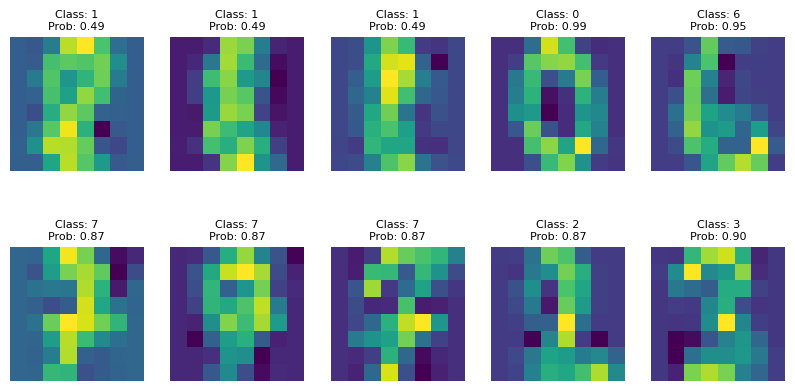

In [13]:
def calculate_sample_probabilities(samples, gmm, X_train, y_train):
    train_labels = gmm.predict(X_train)
    cluster_probabilities = np.zeros((gmm.n_components, 10))  
    for i in range(gmm.n_components):
        cluster_points = y_train[train_labels == i]
        cluster_probabilities[i] = np.bincount(cluster_points, minlength=10) / len(cluster_points)
    
    sample_probs = gmm.predict_proba(samples)
    class_probs = np.dot(sample_probs, cluster_probabilities)
    return class_probs

def plot_generated_samples_with_probs(samples, class_probs, n_row, n_col):
    fig, axes = plt.subplots(n_row, n_col, figsize=(10, 5))
    for i, (sample, probs) in enumerate(zip(samples, class_probs)):
        ax = axes[i // n_col, i % n_col]
        ax.imshow(sample.reshape(8, 8))
        ax.axis('off')
        class_label = np.argmax(probs)
        prob_label = f'Class: {class_label}\nProb: {probs[class_label]:.2f}'
        ax.set_title(prob_label, fontsize=8)
    plt.show()

class_probs = calculate_sample_probabilities(samples, gmm, X_train, y_train)
plot_generated_samples_with_probs(samples, class_probs, 2, 5)

Come si può vedere dalla percentuali di probabilità, le crifre 0, 6 e 3 commentate al punto precedente effettivamente sono quelle generate meglio e classificate nella classe corretta con la percentuale più alta.

## 3. Principal Component Analysis
In this set of exercises we will see how Principal Component Analysis (PCA) can be used to *simplify* the representation of input data in order to make visualize them or to make learning more stable. 

### Exercise 3.1: Fitting a Bayesian Generative Model

Fit a *Quadratic* generative model (e.g. `sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()`) to the Digits dataset. Observe *all* warnings that the model fitting procedure returns. How well does the trained model work?

**Note**: Since we are using a *supervised* model as a downstream task, you should *split* the dataset into training and test sets. 

Accuracy: 0.90
Precision: 0.92
Recall: 0.90



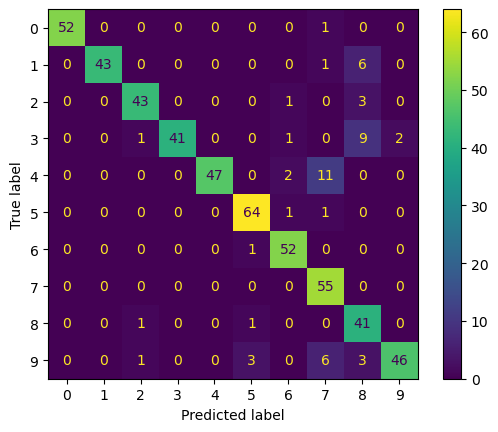

In [14]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

y_pred = qda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}\n')

ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ds.target_names).plot()

Con il modello QDA abbiamo comunque buone prestazioni in termini di accuracy, precision e recall.
Tuttavia alcune classi, come 4, 8 e 9, mostrano più errori di classificazione rispetto ad altre

## Exercise 3.2: Removing "redundant" dimensions

Use *Principal Component Analysis (PCA)* to reduce the dimensionality of the digits dataset. You can use `sklearn.decomposition.PCA` for this. You should think carefully about how to choose the *number* of principal components to use. You should also think *very carefully* about which data is used to estimate the principal components. Use the transformed dataset to train and test a Bayes Quadratic classifier.

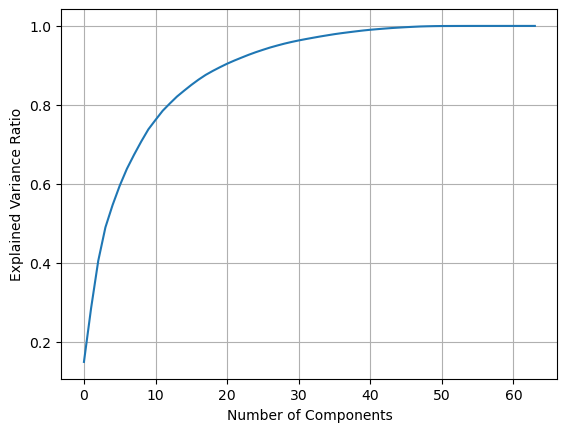


Number of principal components chosen: 21


In [15]:
pca = PCA()
pca.fit(X_train)

# la Explained Variance Ratio indica quanta parte della varianza totale è catturata da ciascuna delle componenti, servirà a capire il numero di componenti principali da scegliere
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Scelgo il numero di componenti principali in base alla Explained Variance Ratio calcolata prima (ad esempio quelli con ratio maggiore o uguale al 90%)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f'\nNumber of principal components chosen: {n_components}')

# Applico al PCA con il numero di componenti principali scelto al passo sopra
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Scegliendo quindi 21 componenti principali (un po' troppi) catturiamo il 90% della varianza totale del dataset. In questo modo andiamo a preservare la maggior parte delle informazioni del dataset originale dopo aver applicato la riduzione. Adesso bisogna capire come performa il modello e se possiamo abbassare ulteriormente questa percentuale, diminuendo quindi ancora il numero di componenti principali.

Number of principal components: 21
Accuracy: 0.98
Precision: 0.98
Recall: 0.98


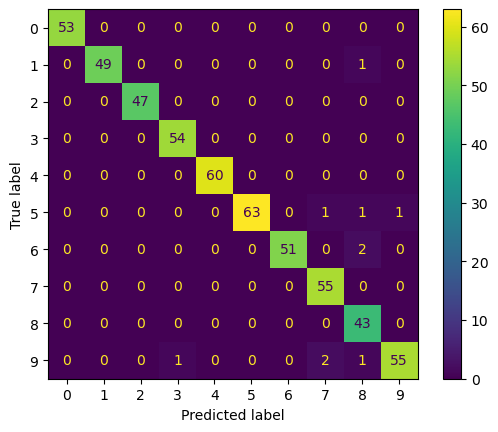

In [16]:
qda.fit(X_train_pca, y_train)

y_pred = qda.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Number of principal components: {n_components}')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ds.target_names).plot()

Vediamo che riducendo la dimensionalità a 21 componenti principali il modello ha potuto mantenere comunque il 90% della varianza originale ma migliorando molto l'accuracy e riducendo il rumore.
Abbiamo inoltre una precision e una recall piuttosto alta, in particolare del 98% e dalla matrice di confusione vediamo che modello classifica correttamente la maggior parte dei campioni di test per ciascuna classe.

Proviamo adesso a ripetere il test abbassando la percentuale di Explained Variance Ratio e quindi anche il numero di componenti principale scelto e vediamo come si comporta il modello.

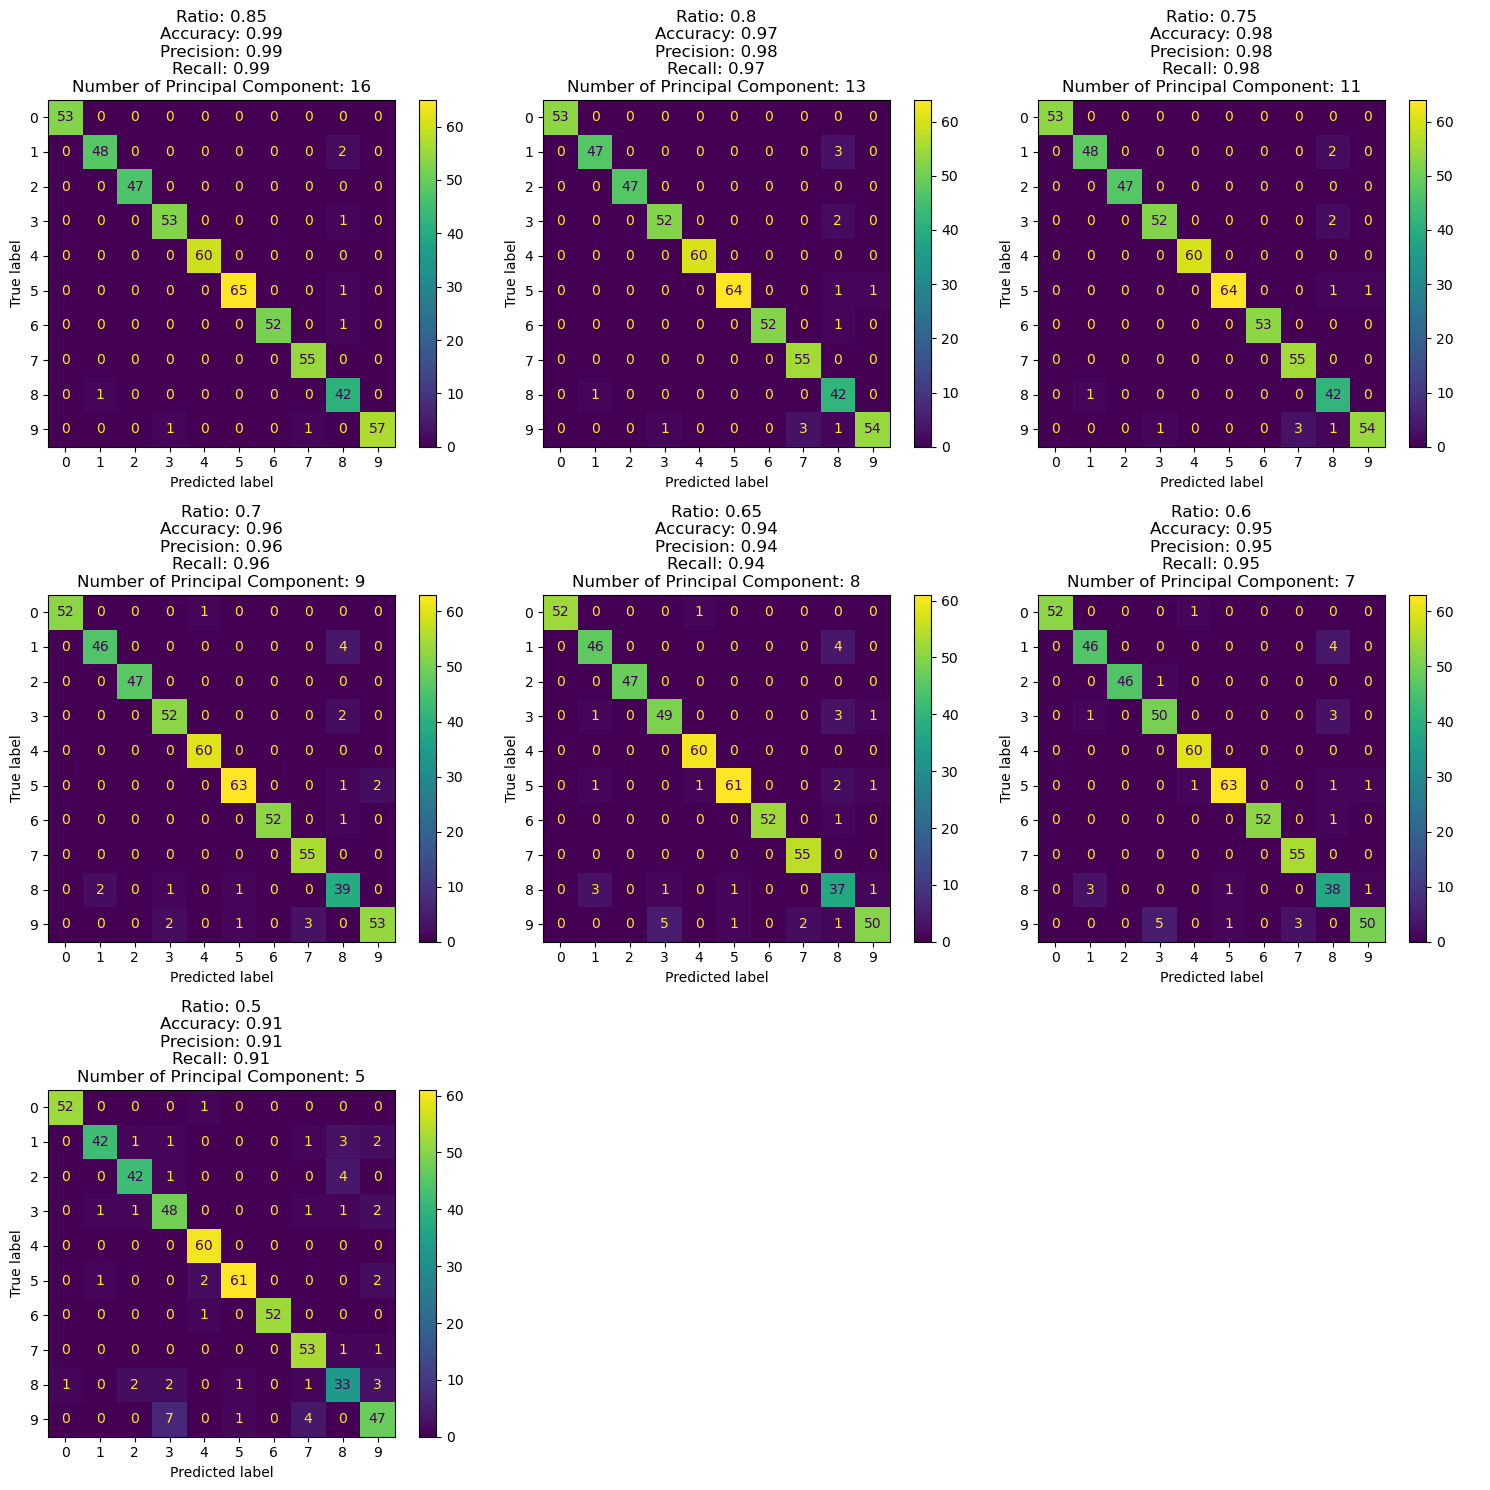

In [17]:
ratios = [0.85, 0.8, 0.75, 0.70, 0.65, 0.6, 0.5]
n_rows = (len(ratios) + 2) // 3 

fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
axes = axes.flatten()  

for idx, ratio in enumerate(ratios):
    n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= ratio) + 1

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    qda.fit(X_train_pca, y_train)

    y_pred = qda.predict(X_test_pca)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    ax = axes[idx]
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ds.target_names).plot(ax=ax, values_format='d')
    ax.set_title(f'Ratio: {ratio}\nAccuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nNumber of Principal Component: {n_components}')

for ax in axes[len(ratios):]:
    ax.axis('off')

plt.subplots_adjust(hspace=2)  # spazio verticale tra i subplot per evitare che le stringhe si sovrappongano
plt.tight_layout()
plt.show()

Si nota immediatamente che anche abbassando notevolmente il numero di componenti principali rispetto al passo sopra, comunque ottentiamo degli ottimi risultati in termini di accuracy, precisio e recall e inoltre, dalla confusion matrix, vediamo che la maggioranza dei dati vengono comunque classificati nel modo corretto. Possiamo quindi abbassare ulteriormente il numero di componenti principali senza alterare le prestazioni del nostro modello.

### Exercise 3.3: PCA as a visualization tool

Transform the Digits dataset onto only *two* dimensions and visualize the dataset using a scatterplot. You can use `ys` to *color* the points in the scatterplot according to the true classes. Do the classes form natural clusters? Do some of them?

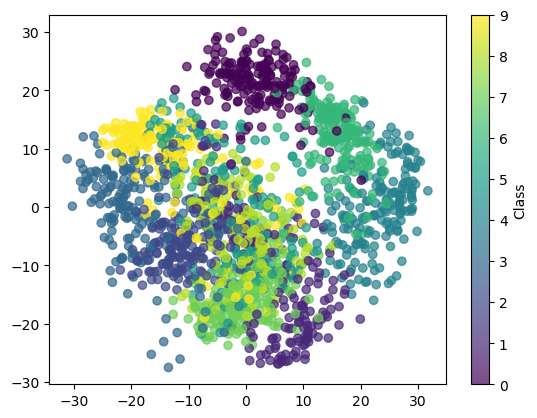

In [18]:
pca = PCA(n_components=2)
Xs_pca = pca.fit_transform(Xs)

scatter = plt.scatter(Xs_pca[:, 0], Xs_pca[:, 1], c=ys, alpha=0.7)
plt.colorbar(scatter, label='Class')
plt.show()

Le classi sembrano distribuite in maniera abbastanza distinta ma con alcune sovrapposizioni. Alcune classi, come la 1 e la 6 sembrano formare cluster naturali nel nuovo spazio, le altre invece mostrano sovrapposizioni, quindi potrebbero essere non facilmente distinguibili con solo 2 componenti principali.

### Exercise 3.4: TSNE for *better* visualization
PCA is severely limited by the fact that it finds a *linear* manifold of the original data. Use `sklearn.manifold.TSNE` instead to learn a 2-dimensional *nonlinear* manifold of digits. Repeat the visualization like before.

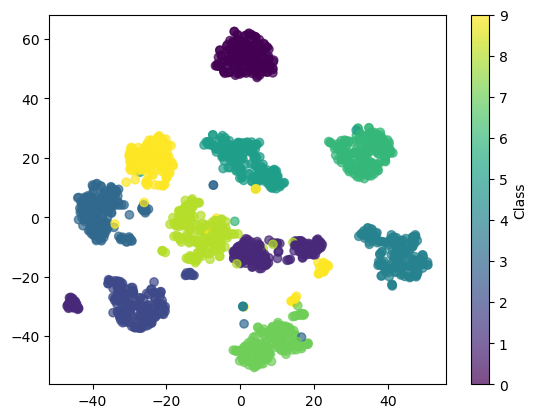

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
Xs_tsne = tsne.fit_transform(Xs)

scatter = plt.scatter(Xs_tsne[:, 0], Xs_tsne[:, 1], c=ys, alpha=0.7)
plt.colorbar(scatter, label='Class')
plt.show()

La maggior parte delle classi adesso sono ben distinte. TSNE è risultato quindi essere molto più efficace.